In [ ]:
!pip install piq

### Importing required packages

In [63]:
import warnings
warnings.filterwarnings(action='ignore')

import argparse
import torch
from torch import nn
from torchvision import models
from torchvision import transforms
from PIL import Image
import os
import numpy as np

import cv2
import matplotlib.pyplot as plt
from google.colab import drive
import glob
from skimage.io import imread
import pandas as pd
import imageio
import piq
from scipy.stats.stats import pearsonr

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


#### NIMA metric rate function

In [39]:
def rate(img_path):
    """
    Returns: Scores, mean, std
    """
    # Number of classes in the dataset
    num_classes = 10
    model_ft = models.densenet121(pretrained=True)
    num_ftrs = model_ft.classifier.in_features
    model_ft.classifier = nn.Sequential(
        nn.Linear(num_ftrs,num_classes),
        nn.Softmax(1)
    )
    # Weight Path
    weight_path = '/content/drive/MyDrive/MLT/dense121_all.pt'
    # Load weights
    assert os.path.exists(weight_path)
    model_ft.load_state_dict(torch.load(weight_path, map_location='cpu'))

    img = Image.open(img_path)
    transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
    img = transform(img)

    with torch.no_grad():
        scores = model_ft(img.view(1,3,224,224))
        weighted_votes = torch.arange(10, dtype=torch.float) + 1
        mean = torch.matmul(scores, weighted_votes)
        std = torch.sqrt((scores * torch.pow((weighted_votes - mean.view(-1,1)), 2)).sum(dim=1))
    return scores.view(-1).numpy(), mean.item(), std.item()

### Reading picture files

In [4]:
pictures_path = '/content/drive/MyDrive/MLT/pictures for lab 4'

In [71]:
dataset = list()
for filename in os.listdir(pictures_path):
    file_path = os.path.join(pictures_path, filename)
    pic_name = file_path.split('/')[-1]
    dataset.append({'name': pic_name,
                    'path': file_path,
                    'mark': int(pic_name[-5])})
dataset = pd.DataFrame(dataset)
dataset = dataset.sort_values(by='mark', ascending=False).reset_index(drop=True)
dataset.head(5)

,name,path,mark
0,paper bot_5.jpg,/content/drive/MyDrive/MLT/pictures for lab 4/...,5
1,plane_5.jpg,/content/drive/MyDrive/MLT/pictures for lab 4/...,5
2,mountains_5.jpg,/content/drive/MyDrive/MLT/pictures for lab 4/...,5
3,hq cat_5.jpg,/content/drive/MyDrive/MLT/pictures for lab 4/...,5
4,pencils_5.jpg,/content/drive/MyDrive/MLT/pictures for lab 4/...,5


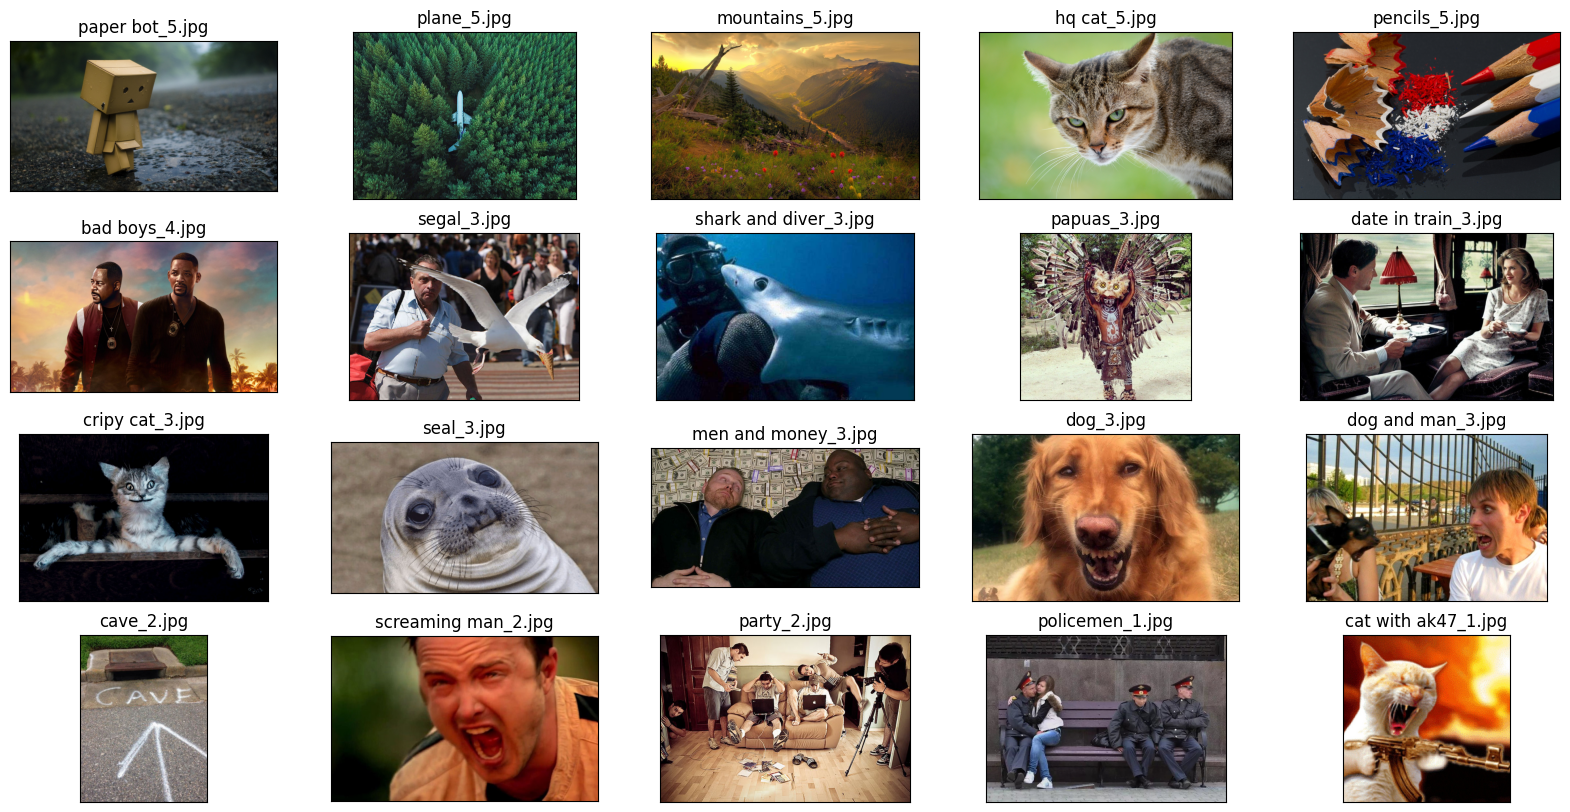

In [73]:
plt.figure(figsize=(20, 10))
for i in range(len(dataset)):
    image = plt.imread(dataset.iloc[i, 1])
    plt.subplot(4, 5, i + 1)
    plt.imshow(image)
    plt.title(dataset.iloc[i, 0])
    plt.xticks([])
    plt.yticks([])

### Calculation TV, BRISQUE and NIMA metrics for each picture

In [74]:
brisque_list = list()
tv_list = list()
nima_list = list()
for i in range(len(dataset)):
    x = torch.tensor(imread(dataset.iloc[i, 1])).permute(2, 0, 1)[None, ...] / 255.
    if torch.cuda.is_available():
        x = x.cuda()
    # BRISQUE metric calculation
    brisque_index: torch.Tensor = piq.brisque(x, data_range=1., reduction='none')
    brisque_list.append(brisque_index.item())
    # TV metric calculation
    tv_index: torch.Tensor = piq.total_variation(x)
    tv_list.append(tv_index.item())
    # Mean NIMA calculation
    cur_nima = rate(dataset.iloc[i, 1])[1]
    nima_list.append(cur_nima)

dataset['tv'] = tv_list
dataset['brisque_index'] = brisque_list
dataset['NIMA mean'] = nima_list
dataset.head(10)

,name,path,mark,tv,brisque_index,NIMA mean
0,paper bot_5.jpg,/content/drive/MyDrive/MLT/pictures for lab 4/...,5,55.550732,19.914917,5.436070
1,plane_5.jpg,/content/drive/MyDrive/MLT/pictures for lab 4/...,5,681.340332,9.352600,5.438912
2,mountains_5.jpg,/content/drive/MyDrive/MLT/pictures for lab 4/...,5,230.047134,22.596558,5.422800
3,hq cat_5.jpg,/content/drive/MyDrive/MLT/pictures for lab 4/...,5,207.596924,10.527344,5.402219
4,pencils_5.jpg,/content/drive/MyDrive/MLT/pictures for lab 4/...,5,141.909348,10.565979,5.409184
5,bad boys_4.jpg,/content/drive/MyDrive/MLT/pictures for lab 4/...,4,63.747452,33.405396,5.436094
6,segal_3.jpg,/content/drive/MyDrive/MLT/pictures for lab 4/...,3,96.691193,25.561218,5.422778
7,shark and diver_3.jpg,/content/drive/MyDrive/MLT/pictures for lab 4/...,3,34.714729,35.991211,5.417792
8,papuas_3.jpg,/content/drive/MyDrive/MLT/pictures for lab 4/...,3,251.581497,8.004700,5.416360
9,date in train_3.jpg,/content/drive/MyDrive/MLT/pictures for lab 4/...,3,113.426239,16.602234,5.400877


### Calculation Pearson's correlation

In [56]:
my_marks = dataset['mark'].to_numpy()

mm_bi_corr = round(pearsonr(my_marks, brisque_list)[0], 6)

mm_tv_corr = round(pearsonr(my_marks, tv_list)[0], 6)

mm_nima_corr = round(pearsonr(my_marks, nima_list)[0], 6)

print(f'Pearson corr between mine and TV: {mm_tv_corr},\n\nPearson corr between mine and BRISQUE: {mm_bi_corr},\n\nPearson corr between mine and NIMA: {mm_nima_corr}.')

Pearson corr between mine and TV: 0.473421,

Pearson corr between mine and BRISQUE: -0.474049,

Pearson corr between mine and NIMA: 0.45581.


#### As one can see from the results obtained above, we can conclude that all metrics show almost simillar results. Since BRISQUE is "the lower the better", that the reason why we have negative value of correlation.
#### So in our case all metrics had performed well.